In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set()
import gc

---

# Loading Data

In [2]:
%%time
df = pd.read_parquet('../data/interim/sample2m.parquet')

CPU times: user 3.52 s, sys: 767 ms, total: 4.29 s
Wall time: 2.86 s


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241793 entries, 0 to 2241792
Data columns (total 22 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   hashtags                            object        
 1   present_media                       object        
 2   present_links                       object        
 3   present_domains                     object        
 4   tweet_type                          category      
 5   language                            category      
 6   tweet_timestamp                     datetime64[ns]
 7   engaged_with_user_id                object        
 8   engaged_with_user_follower_count    int64         
 9   engaged_with_user_following_count   int64         
 10  engaged_with_user_is_verified       bool          
 11  engaged_with_user_account_creation  datetime64[ns]
 12  engaging_user_id                    object        
 13  engaging_user_follower_count        int64 

In [4]:
features = ['engaged_with_user_follower_count', 'engaged_with_user_following_count', 'engaging_user_follower_count', 'engaging_user_following_count']
target = 'TARGET_reply'

---

# Holdout validation

In [5]:
df.sort_values('tweet_timestamp', inplace=True)

In [6]:
training_df = df[df['tweet_timestamp'].dt.day < 20]

In [7]:
len(training_df) / len(df)

0.762984807250268

In [8]:
validation_df = df[df['tweet_timestamp'].dt.day >= 20]

In [9]:
len(validation_df) / len(df)

0.237015192749732

---

This is a very imbalanced binary classification problem. Only 2.9% of the samples are positive.
This means that a classifier which always returns 0 will achieve 97.1% accuracy.

In [10]:
training_df[target].value_counts(normalize=True)

0    0.970792
1    0.029208
Name: TARGET_reply, dtype: float64

In [11]:
validation_df[target].value_counts(normalize=True)

0    0.971071
1    0.028929
Name: TARGET_reply, dtype: float64

---

# Scoring functions

In [12]:
from sklearn.metrics import average_precision_score, log_loss

def calculate_ctr(gt):
    positive = len([x for x in gt if x == 1])
    ctr = positive/float(len(gt))
    return ctr

def relative_cross_entropy_score(gt, pred):
    cross_entropy = log_loss(gt, pred)
    data_ctr = calculate_ctr(gt)
    strawman_cross_entropy = log_loss(gt, [data_ctr for _ in range(len(gt))])
    return (1.0 - cross_entropy/strawman_cross_entropy)*100.0

def compute_score(y_true, y_score):
    ap = average_precision_score(y_true, y_score)
    rce = relative_cross_entropy_score(y_true, y_score)
    return ap, rce

---

# Baseline Models

## Most frequent class

In [13]:
print('{:.4f} and {:.4f}'.format(*compute_score(validation_df[target], np.zeros(len(validation_df)))))

0.0289 and -662.7297


## Random

In [14]:
print('{:.4f} and {:.4f}'.format(*compute_score(validation_df[target], np.random.rand(len(validation_df)))))

0.0291 and -663.3940


Almost no difference between predicting the most frequent class and just random predictions.

In line with the leaderboard's random predictions which are around `0.0227, -822.4109`

---

# XGBoost Model

In [15]:
import xgboost as xgb

In [16]:
dtrain = xgb.DMatrix(data=training_df[features], label=training_df[target])

In [17]:
xgb_parameters = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

In [18]:
%%time
model = xgb.train(xgb_parameters, dtrain=dtrain)

CPU times: user 26.1 s, sys: 14.7 ms, total: 26.1 s
Wall time: 6.63 s


In [19]:
dvalid = xgb.DMatrix(data=validation_df[features])

In [20]:
print('{:.4f} and {:.4f}'.format(*compute_score(validation_df[target], model.predict(dvalid))))

0.0445 and -1.6484


## Critique

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

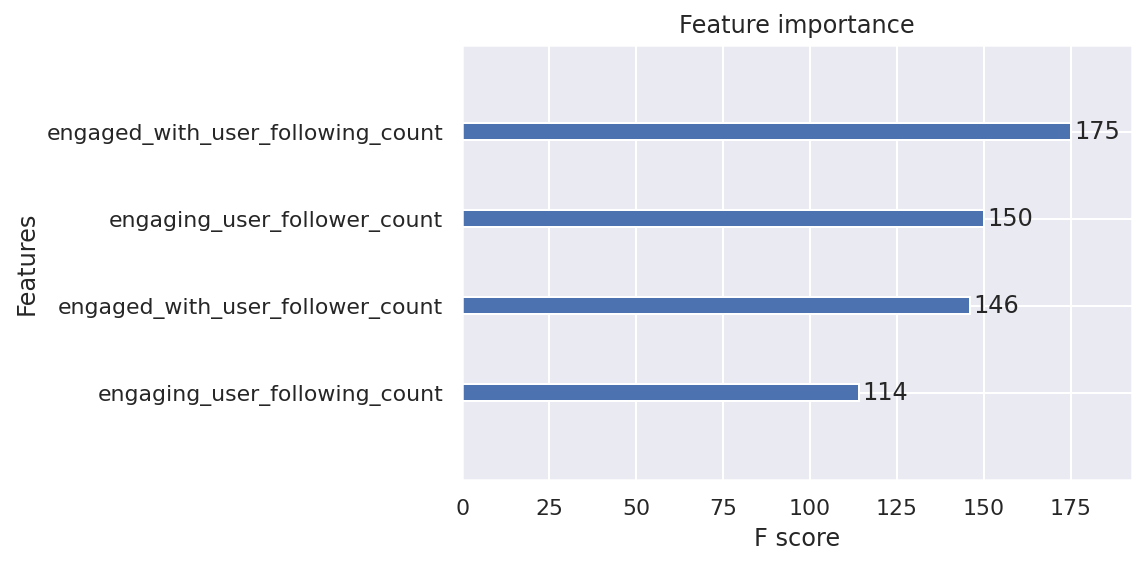

In [21]:
from xgboost import plot_importance
plot_importance(model)